## Etherium Gas Analytics
This notebook has three section:
- Data preparation
- Exploratory Analysis
- Max and Priority Fee Recommendations

## Data preparation

### Libs Import / Installation for Google Colab

In [9]:
%%capture
!pip install web3 kaleido

In [2]:
#Restart runtime after this step for Colab!!!
%%capture
!pip install --force-reinstall jsonschema==3.2.0 

In [1]:
from google.colab import drive
import json
import os
import sys
import web3
from web3 import Web3, HTTPProvider
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

### Mount GDrive and Import Utils Module

In [2]:
#Moount
drive.mount('/content/drive')

#Project
project_path = '/content/drive/MyDrive/Colab Notebooks/ETH_Analytics/'

#Load keys json
keys_path = os.path.join(project_path, 'keys.json')
with open(keys_path,'r') as f:
  keys_dict = json.load(f)

#Insert lib path to sys
sys.path.insert(0, os.path.join(project_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import utility functions
from src.utils import *

### Constants

In [4]:
#Constants
gwei_to_eth = 1/1e9
wei_to_gwei = 1/1e9

#Save path for temp csv
save_path_trans = os.path.join(project_path, 'data/temp_trans.csv')
save_path_block = os.path.join(project_path, 'data/temp_block.csv')

### Setup Connection

In [5]:
#Connect
rivet_url = keys_dict['rivet_url']
w3 = Web3(HTTPProvider(rivet_url))
#Check connection
w3.isConnected()

True

### Fetch Data

In [27]:
#Get n blocks
blocks = get_latest_n_blocks(w3)
#Get all Transactions from block
transactions = get_all_transactions(w3, blocks)

In [28]:
#Create trans df
df = create_transaction_df(transactions)
#Create block df
df_block = create_block_df(blocks)
#Join blocks data to trans
df = pd.merge(df, df_block, left_on='blockNumber', right_on='number')

#Save cvs
df_block.to_csv(save_path_block, index=False)
df.to_csv(save_path_trans, index=False)

### Preprocess Data

In [7]:
#Read from csv (checkpoint)
df = pd.read_csv(save_path_trans)
df_block = pd.read_csv(save_path_block)

In [8]:
#Select London
df = df[df['type'] == '0x2'].copy()

#Convert to gwei
df['baseFeePerGas_gwei'] = df['baseFeePerGas'] * wei_to_gwei
df['maxPriorityFeePerGas_gwei'] = df['maxPriorityFeePerGas'] * wei_to_gwei
df['maxFeePerGas_gwei'] = df['maxFeePerGas'] * wei_to_gwei
df['gasPrice_gwei'] = df['gasPrice'] * wei_to_gwei

#Value to ETH
df['value_eth'] = df['value'].map(lambda x: x[0 : max(0, len(x)-18)] + '.' + x[max(0, len(x)-18) : len(x)])
df['value_eth'] = df['value_eth'].map(lambda x: '0' + x if x.startswith('.') else x).astype('float')

#Priority Fee Outliers
median = df['maxPriorityFeePerGas_gwei'].median()
df['pf_outlier'] = -df['maxPriorityFeePerGas_gwei'].between(0, 3 * median)

#Total price
df['totalPrice_gwei'] = df['gasPrice_gwei'] * df['gas'] 

#Gas usage ratio
df['gas_ratio'] = df['gasUsed']  / df['gasLimit']

##Exploratory Analysis - Last N Blocks

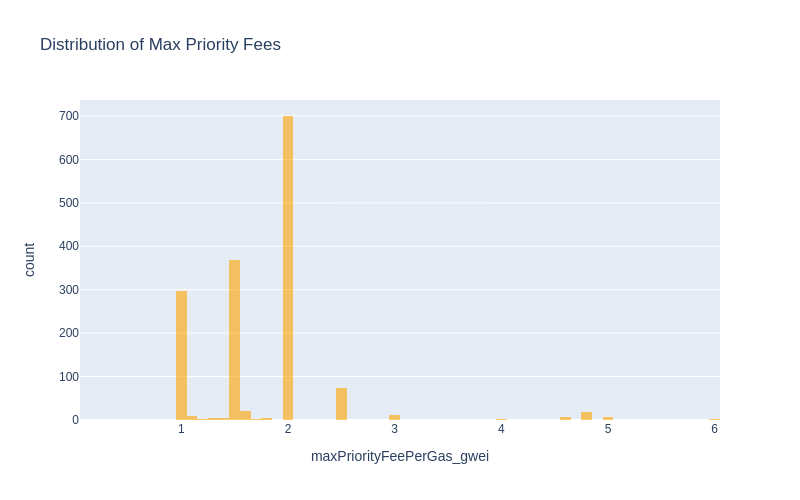

In [10]:
#DF to plot
topl = df[-df['pf_outlier']]
fig = px.histogram(topl, x='maxPriorityFeePerGas_gwei', color_discrete_sequence=['orange'], opacity=0.6,\
             title='Distribution of Max Priority Fees', width = 800)
#Create static image
create_and_open_static_img(project_path, 'plt_1.png', fig)

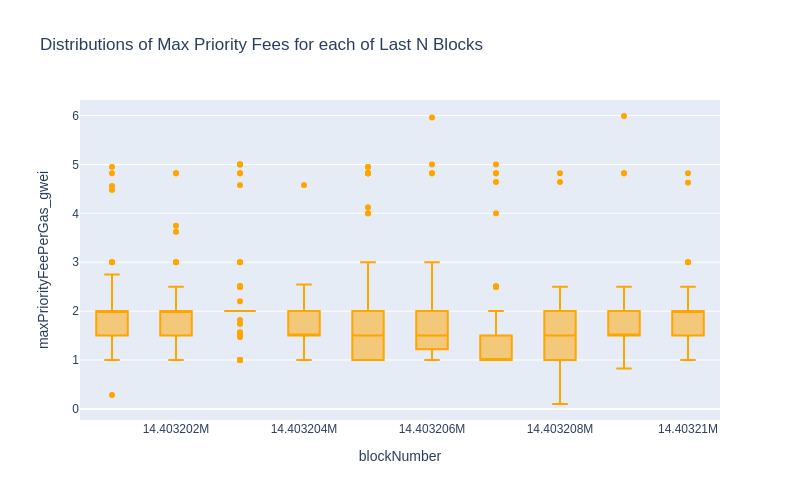

In [15]:
#DF to plot
topl = df[-df['pf_outlier']]
fig = px.box(topl, x='blockNumber', y='maxPriorityFeePerGas_gwei',color_discrete_sequence=['orange'],\
       title='Distributions of Max Priority Fees for each of Last N Blocks',  width = 800)
#Create static image
create_and_open_static_img(project_path, 'plt_2.png', fig)

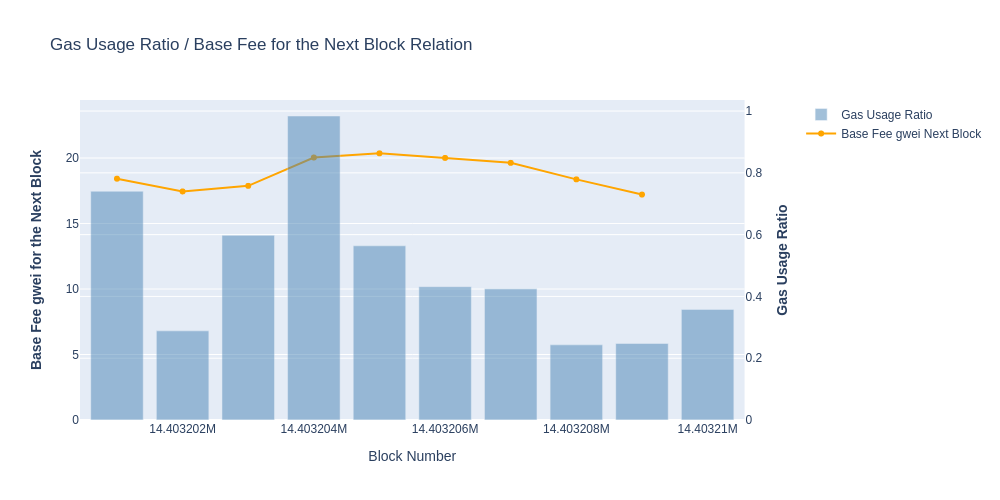

In [12]:
#DF to plot
topl = df.groupby('blockNumber', as_index=False)[['gas_ratio', 'baseFeePerGas_gwei']].first()
#Shift one block
topl['baseFeePerGas_gwei'] = topl['baseFeePerGas_gwei'].shift(-1).dropna()

# Create figure 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=topl['blockNumber'], y=topl['gas_ratio'], name="Gas Usage Ratio", marker_color='steelblue',opacity=0.5), 
    secondary_y=True
)
fig.add_trace(
    go.Scatter(x=topl['blockNumber'], y=topl['baseFeePerGas_gwei'], name="Base Fee gwei Next Block", marker_color='orange'),
    secondary_y=False
)

# Add figure title
fig.update_layout(
    title_text="Gas Usage Ratio / Base Fee for the Next Block Relation",
    width=1000
)

# Set x-axis title
fig.update_xaxes(title_text="Block Number")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Gas Usage Ratio</b>", secondary_y=True)
fig.update_yaxes(title_text="<b>Base Fee gwei for the Next Block</b> ", secondary_y=False)

fig.update_layout(yaxis_range=[0,topl['baseFeePerGas_gwei'].max() * 1.2])

#Create static image
create_and_open_static_img(project_path, 'plt_3.png', fig)

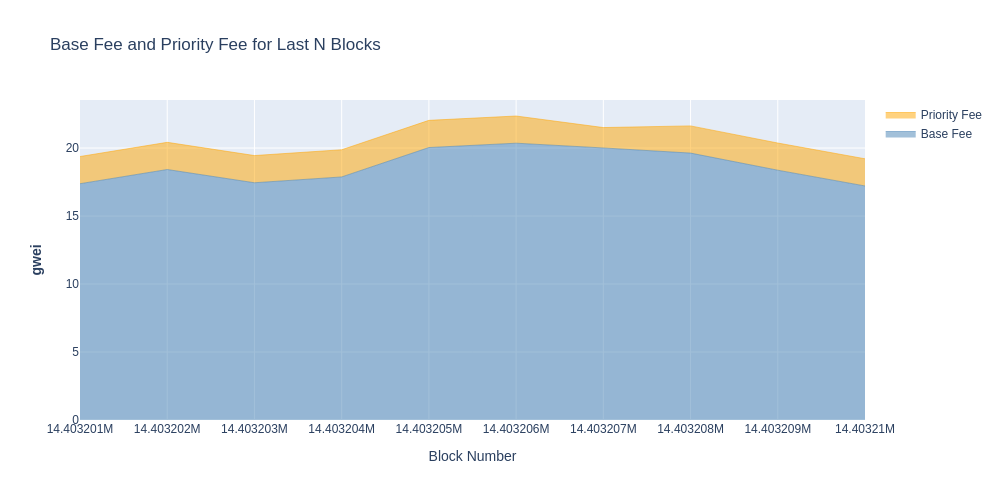

In [13]:
#Take 75th percentile for Priority Fess
topl = df.groupby(['blockNumber','baseFeePerGas_gwei'], as_index=False)['maxPriorityFeePerGas_gwei'].\
          apply(lambda x: np.percentile(x, 75))

# Create figure 
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
     x=topl['blockNumber'], y = topl['baseFeePerGas_gwei'],
     name = 'Base Fee',
     mode = 'lines',
     line=dict(width=0.5, color='steelblue'),
     stackgroup = 'one'))

fig.add_trace(go.Scatter(
     x=topl['blockNumber'], y = topl['maxPriorityFeePerGas_gwei'],
     name = 'Priority Fee',
     mode = 'lines',
     line=dict(width=0.5, color='orange'),
     stackgroup = 'one'))

# Add figure title
fig.update_layout(
    title_text="Base Fee and Priority Fee for Last N Blocks",
    width=1000
)

# Set x-axis title
fig.update_xaxes(title_text="Block Number")

# Set y-axes titles
fig.update_yaxes(title_text="<b>gwei</b>")

#Create static image
create_and_open_static_img(project_path, 'plt_4.png', fig)

## Priority Fees Estimation

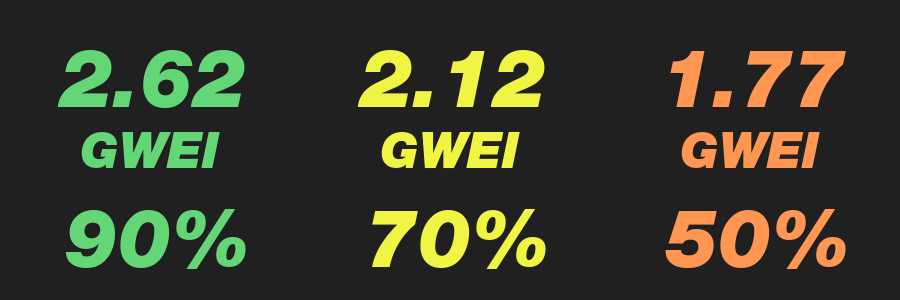

In [14]:
#Fees estimates based on percentiles
tocalc = df[-df['pf_outlier']]['maxPriorityFeePerGas_gwei']
#Model as normal distribution
mean = tocalc.mean()
std = tocalc.std()
p90 = np.round(scipy.stats.norm.ppf(0.90, loc=mean, scale=std), 2)
p70 = np.round(scipy.stats.norm.ppf(0.70, loc=mean, scale=std), 2)
p50 = np.round(scipy.stats.norm.ppf(0.50, loc=mean, scale=std), 2)

#Create Images
#Font file
font_file = os.path.join(project_path, 'fonts', 'helvetica.ttf')
img_h = create_one_block(text = str(p90), text_class = '90%', color = (99, 214, 118), font_file=font_file)
img_m = create_one_block(text = str(p70), text_class = '70%', color = (239, 245, 66), font_file=font_file)
img_l = create_one_block(text = str(p50), text_class = '50%', color = (255, 151, 82), font_file=font_file)#255, 180, 82

#Concatenate
img_arr = np.concatenate((np.array(img_h), np.array(img_m), np.array(img_l)), axis=1)
img = Image.fromarray(img_arr, 'RGB')
#Save
img.save(os.path.join(project_path, 'plots/plt_5.png'))
img

## Final Taghuts
Ideas for improvement of Priority Fees estimation:
- Create estimates based on minimal priority fees
- Prediction of priority fees (for various inclusion probabilities ) instead of simple statistical estimation 
- Prediction of gas usage ratio (how full is a block) could help get lower prices 
- Features to consider for prediction of gas usage ratio might include time components(time of day, day of week), gas usage history(autoregresssive features), etc.
